In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


dataframe=pd.read_csv('./Iot_Windows_10_random.csv')
model = joblib.load('Iot_model_multi.pkl')

C:\Users\Alperen\AppData\Local\Temp\ipykernel_5764\1893639031.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\Alperen\AppData\Local\Temp\ipykernel_5764\1893639031.py:8: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,45,46,49,51,52,54,56,58,59,60,61,62,71,72,73,74,76,79,80,84,95,98,100,101,102,103,105,106,107,109,111,112,113,114,115,116,117,118,119,120,121,122,123) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe=pd.read_csv('./Iot_Windows_10_random.csv')


In [2]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder oluştur
label_encoder = LabelEncoder()

# 'type' sütununu sayısallaştır
dataframe['type_encoded'] = label_encoder.fit_transform(dataframe['type'])

dataframe= dataframe.drop("type", axis=1)

# Tüm sütunları float64'e dönüştür
dataframe = dataframe.apply(pd.to_numeric, errors='coerce', axis=1)

# 'label' sütununun diğer sütunlarla korelasyonları
correlations = dataframe.corr()['type_encoded']

# NaN değerlere sahip sütunları filtrele
columns_to_drop = correlations[correlations.isna()].index

# NaN değerlere sahip sütunları DataFrame'den çıkar
dataframe = dataframe.drop(columns=columns_to_drop, axis=1)

# 'label' sütununun diğer sütunlarla korelasyonları
columns_add = []
for column, correlation in correlations.items():
    if 0 < correlation < 0.14972162479892778:
        columns_add.append(column)
    elif -0.1645839900029373 <= correlation < 0:
        columns_add.append(column)
        

columns_add.append("type_encoded")

# Seçilen sütunları DataFrame'den al
dataframe_selected = dataframe[columns_add]


dataframe_selected = dataframe_selected.fillna(0)

In [3]:
tahmin_sozlugu = {0: 'ddos', 1: 'dos', 2: 'injection', 3: 'mitm', 4: 'normal', 5: 'password', 6: 'scanning', 7: 'xss'}


# Rasgele satır indeksi seçin
random_row_index = np.random.randint(0, dataframe_selected.shape[0])

# Seçilen rastgele satırı alın
# Modelin beklediği özellik sayısını alın
beklenen_ozellik_sayisi = len(model.feature_importances_)

# Rastgele seçilen giriş verisini alın
rastgele_giris = dataframe_selected.iloc[random_row_index]

# Giriş verisini modelin beklediği özellik sayısına getirin
rastgele_giris = rastgele_giris.values.reshape(1, -1)[:,:beklenen_ozellik_sayisi]

# Tahmin yapın
tahmin = model.predict(rastgele_giris)

print("Tahminler:", tahmin_sozlugu[tahmin[0]])



Tahminler: xss


In [4]:
X = dataframe_selected.drop(["type_encoded"], axis=1).values

tahmin = model.predict(X)
        
tahmin_df = pd.DataFrame({"label": tahmin})

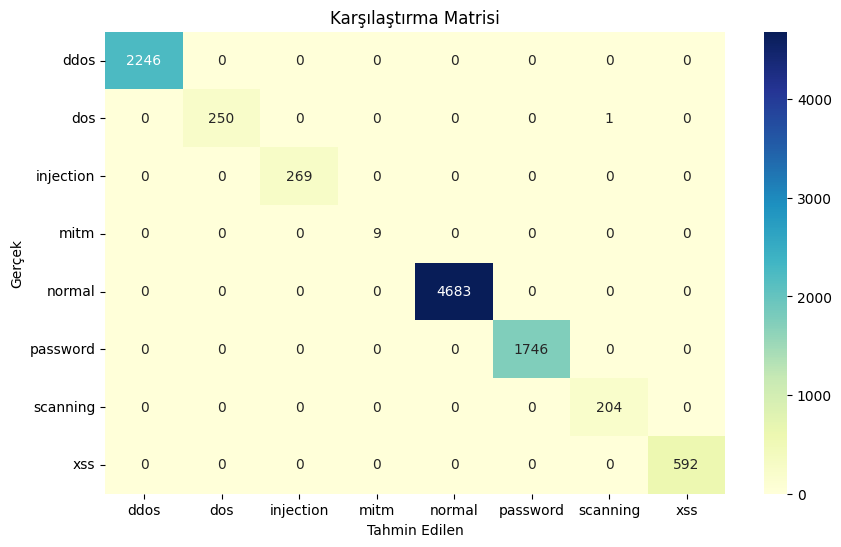

In [5]:


class_names = ['ddos', 'dos' ,'injection' ,'mitm', 'normal', 'password', 'scanning', 'xss']
from sklearn.metrics import confusion_matrix

# Tahminleri doğrulamak için gerçek etiketleri alın
gercek_etiketler = dataframe_selected["type_encoded"].values

# Karşılaştırma matrisi oluşturun
cm = confusion_matrix(gercek_etiketler, tahmin)

# Karşılaştırma matrisini görselleştirin
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Karşılaştırma Matrisi')
plt.show()